In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r1_range = [0,8]
r2_range = [5,12]

num_points = 1000
r1 = np.array([np.random.uniform(low=r1_range[0], high=r1_range[1], size=int(num_points/2)), np.random.uniform(low=0, high=2*np.pi, size=int(num_points/2)), ['A']*int(num_points/2)  ]).T
r2 = np.array([np.random.uniform(low=r2_range[0], high=r2_range[1], size=int(num_points/2)), np.random.uniform(low=0, high=2*np.pi, size=int(num_points/2)), ['B']*int(num_points/2) ]).T

df = pd.DataFrame(np.vstack((r1,r2)), columns = ['r','theta','type'])
df[['r','theta']] = df[['r','theta']].astype(float)
df['x'] = df.r * np.cos(df.theta.values)
df['y'] = df.r * np.sin(df.theta)
df.drop(['r','theta'], axis = 1,inplace = True)
df

,type,x,y
0,A,0.112780,5.151481
1,A,-1.247077,0.176788
2,A,0.245522,-2.099750
3,A,6.313865,-4.587824
4,A,3.183726,3.618359
...,...,...,...
995,B,-9.842980,-2.510244
996,B,1.814066,7.512033
997,B,8.662061,2.618088
998,B,-4.239666,-2.754272


### Task
- Plot x,y in a scatterplot, colour code by "type"


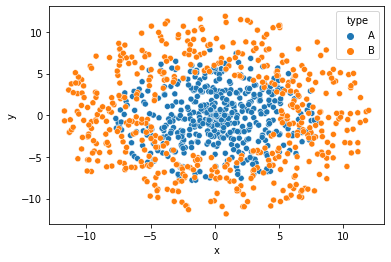

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.scatterplot(data = df, x = 'x', y = 'y', hue = 'type')

- Think about what separates "A" from "B", can a value(s) be used/made that would help predict the Type of a point? Do so in df. (Try this yourself first before moving to next point) 

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


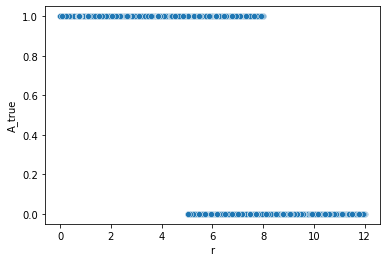

In [5]:
df['r'] = np.sqrt(df['x']**2 + df['y']**2)
df['A_true'] = (df['type'] == 'A').astype(int)
sns.scatterplot(df['r'], df['A_true'])

Make a sigmoidal function $S$ with:
- $x$ - variable
- $\alpha, \beta$ - parameters

$ \hat{y} = S(x) = \frac{1}{1 + \exp(\alpha +\beta x)}$ \
$ \hat{y} = S(x) = \frac{1}{1 + \exp(X\theta)}$ \


Plot $A$ vs $R$ as above, but include the sigmoidal function $S(R)$ in the plot. Manually alter the values of $\alpha$ and $\beta$ until you are somewhat close to the best representation of the data (subjective, doesn't need to be exact) 

In [6]:
#sigmoid
alpha = -7
beta = 1.25
x = np.linspace(0,12,50)
y = 1/( 1 + np.exp(alpha+beta*x) )
plt.plot(x,y)
sns.scatterplot(df['r'], df['A_true'])

NameError: ignored

## Perform Logisitic Regression. Use $R$ to classify Type

### Using sklearn Logistic Regression class
Use link:
https://www.youtube.com/watch?v=FEksNK_i7lQ
- Import sklearn's Logistic Regression (LR) class
- Normalise/ scale $R$
- Split into train and test sets
- Use LR class on $R$ to predict Type

In [81]:
# from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn import preprocessing



In [82]:
#scaled R
# df_r_scaled = df['r']/df['r'].max()
df_r = df['r'].values
df_a = df['A_true'].values

scaler = preprocessing.StandardScaler().fit(df_r.reshape(df_r.shape[0],-1) )
X_scaled = scaler.transform(df_r.reshape(df_r.shape[0],-1) )
X_train, X_test, y_train, y_test = train_test_split(X_scaled, df_a, test_size = 0.25 ,random_state=42)# scaler and preprocessing make be duped (might be wrong about that)

# pipe = make_pipeline(StandardScaler(), LogisticRegression())
# pipe.fit(X_train, y_train)  # apply scaling on training data
# enc = Pipeline(steps=[('standardscaler', StandardScaler()),
#                 ('logisticregression', LogisticRegression())])
# pipe.score(X_test, y_test)  # apply scaling on testing data, without leaking training data.
# 0.96
X_train = X_train.reshape(X_train.shape[0],-1)
X_test = X_test.reshape(X_test.shape[0],-1)
actual = y_train

In [101]:
#### 1. Import and initialize/instanciate the model
lr = LogisticRegression(solver='newton-cg', random_state=0,max_iter=500)

#### 2. fit the model/training
lr.fit(X_train, y_train)

#### 3. Evaluate the model
train_preds = lr.predict(X_train)
train_pred_diff = sum(actual-train_preds)

### evaluation on training
tr_r2 = r2_score(y_train, train_preds)
tr_mse = mean_squared_error(y_train, train_preds)
print('train r2 = ', tr_r2)
print('train mse = ', tr_mse)

### get the predictions on test 
test_preds = lr.predict(X_test)

### evaluation on test
ts_r2 = r2_score(y_test, test_preds)
ts_mse = mean_squared_error(y_test, test_preds)
print('test r2 = ', ts_r2)
print('test mse = ', ts_mse)
### high performance on training and low scores/perfomance on testing ---> overfitting
lr.score(X_train,y_train)


train r2 =  0.16261307390339663
train mse =  0.20933333333333334
test r2 =  0.24756659836065575
test mse =  0.188


0.7906666666666666

In [93]:
#### 4. tuning (opt)
#### fine tuning 
#### two ways of fine tuning the models
#### randomized search : pick random combinations of parameters and select the ones giving best scores
### grid-search brute force: try all combinations of parameters and select the ones giving best scores

grid_values = {'penalty': ['l2'], 'C': [   0.        ,0.5,1,5,10,50,  111.11111111,  222.22222222,  333.33333333,
        444.44444444,  555.55555556,  666.66666667,  777.77777778,
        888.88888889, 1000.        ]}
model_lr = GridSearchCV(lr, param_grid=grid_values,cv=5, verbose=2)

X = np.nan_to_num(X_train)
y = np.nan_to_num(y_train)
model_lr.fit(X,y)
model_lr.best_score_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ..................................C=0.0, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.0, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.0, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.0, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.0, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l2; total time=   0.0s
[CV] END ..................................C=0.5, penalty=l2; total time=   0.0s
[CV] END ....................................C=1, penalty=l2; total time=   0.0s
[CV] END ....................................C=1

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py", line 1589, in fit
    fold_coefs_ = Parallel(
  File "/usr/local/lib/python3.8/dist-packages/joblib/parallel.py", line 1085, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.8/dist-packages/joblib/para

0.792

In [94]:
train_preds = model_lr.predict(X)
### evaluation on training
tr_r2 = r2_score(y, train_preds)
tr_mse = mean_squared_error(y, train_preds)
print('train r2 = ', tr_r2)
print('train mse = ', tr_mse)

### get the predictions on test 
test_preds = model_lr.predict(X_test)

### evaluation on test
ts_r2 = r2_score(y_test, test_preds)
ts_mse = mean_squared_error(y_test, test_preds)
print('test r2 = ', ts_r2)
print('test mse = ', ts_mse)

train r2 =  0.17328042328042337
train mse =  0.20666666666666667
test r2 =  0.24756659836065575
test mse =  0.188


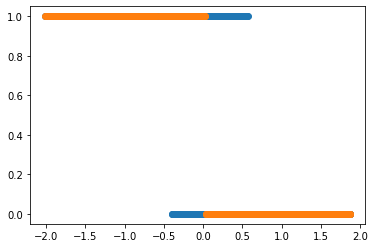

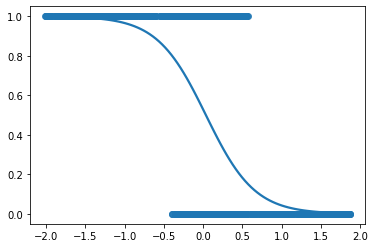

In [86]:
plt.scatter(X,y)
plt.scatter(X,train_preds)
plt.show()
plt.scatter(X_test,y_test)
plt.scatter(X_test,test_preds)
plt.show()
sns.regplot(x=X, y=y, logistic=True, ci=None)

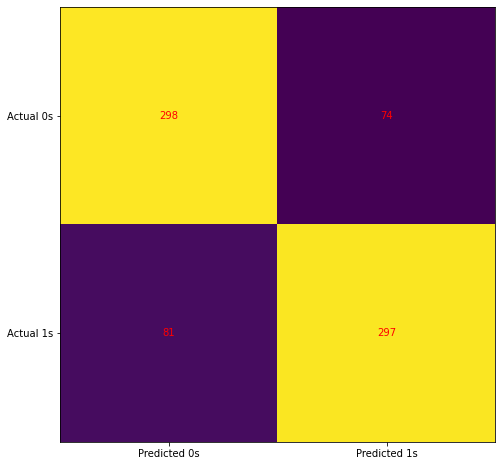

              precision    recall  f1-score   support

           0       0.79      0.80      0.79       372
           1       0.80      0.79      0.79       378

    accuracy                           0.79       750
   macro avg       0.79      0.79      0.79       750
weighted avg       0.79      0.79      0.79       750



In [100]:
#calculate confusion matrix
y_pro = model_lr.predict_proba(X)
cm = confusion_matrix(y, model_lr.predict(X))

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

print(classification_report(y, model_lr.predict(X)))

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve

class NeverClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict(X_train)
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")
skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

never_clf = NeverClassifier()
cross_val_score(never_clf, X_train, y_train, cv=3, scoring="accuracy")

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

confusion_matrix(y_train, y_train_pred)

y_train_perfect_predictions = y_train  # pretend we reached perfection
confusion_matrix(y_train, y_train_perfect_predictions)

precision_score(y_train, y_train_pred)

y_scores = sgd_clf.decision_function(X_)
y_scores


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)



NameError: ignored

### Use manual gradient descent function
- Repeat as above up to and including bullet point 3.
- Define a LR cost function using links provided in Jordan's Plan google sheets doc.
- Use your gradient descent algorithm to find minimum of cost function

In [ ]:
def logreg_cost():
  return y log h(X) - (1-y)log(1-h(X))

def grad_descent(X, Y, theta0, cost_function):
  return X

  